# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

### 1. Познакомимся с данными

In [1]:
import pandas as pd
import numpy as np

In [2]:
geo = pd.read_excel('/home/data/netology_ml/data/hw2 (clustering)/geo.xlsx')
geo_comment = pd.read_excel('/home/data/netology_ml/data/hw2 (clustering)/geo_comment.xlsx')

In [3]:
geo.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


### 2. Визуализация
Попробуем что-нибудь отрисовать.
Благодаря Хабру и ODS открыл для себя вот этих ребят [NEXTGIS](http://nextgis.ru/services/dataosm/)
У них забрал геоданные о географии и административном делении Москвы.
загружу все это в объект GeoDataFrame

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas.geoseries import *
%matplotlib inline

In [5]:
geo_data = gpd.read_file('/home/data/geo_data/shapefile-example/data/boundary-polygon.shp')
geo_data = geo_data[(geo_data.ADMIN_LVL == '5') & 
                    (geo_data.NAME != 'Новомосковский административный округ') & 
                    (geo_data.NAME != 'Троицкий административный округ')]
geo_data = geo_data[['NAME', 'geometry']]
geo_data

,NAME,geometry
0,Центральный административный округ,"POLYGON ((37.5893281 55.7924067, 37.5894238 55..."
31,Северный административный округ,"(POLYGON ((37.5070247 55.7778085, 37.5067627 5..."
34,Зеленоградский административный округ,"POLYGON ((37.2524878 55.9678978, 37.2526505 55..."
41,Юго-Западный административный округ,"POLYGON ((37.5925916 55.5598474, 37.589454 55...."
45,Восточный административный округ,"(POLYGON ((37.8405143 55.8024712, 37.8409022 5..."
57,Юго-Восточный административный округ,"(POLYGON ((37.6658108 55.7316354, 37.6662402 5..."
58,Южный административный округ,"POLYGON ((37.6022876 55.5663727, 37.598397 55...."
83,Северо-Восточный административный округ,"POLYGON ((37.5865301 55.7934376, 37.5857332 55..."
119,Северо-Западный административный округ,"POLYGON ((37.3849555 55.8090616, 37.3850513 55..."
159,Западный административный округ,"(POLYGON ((37.3936145 55.6947794, 37.3933397 5..."


In [6]:
geo_data = geo_data.to_crs({'init': 'epsg:3857'})

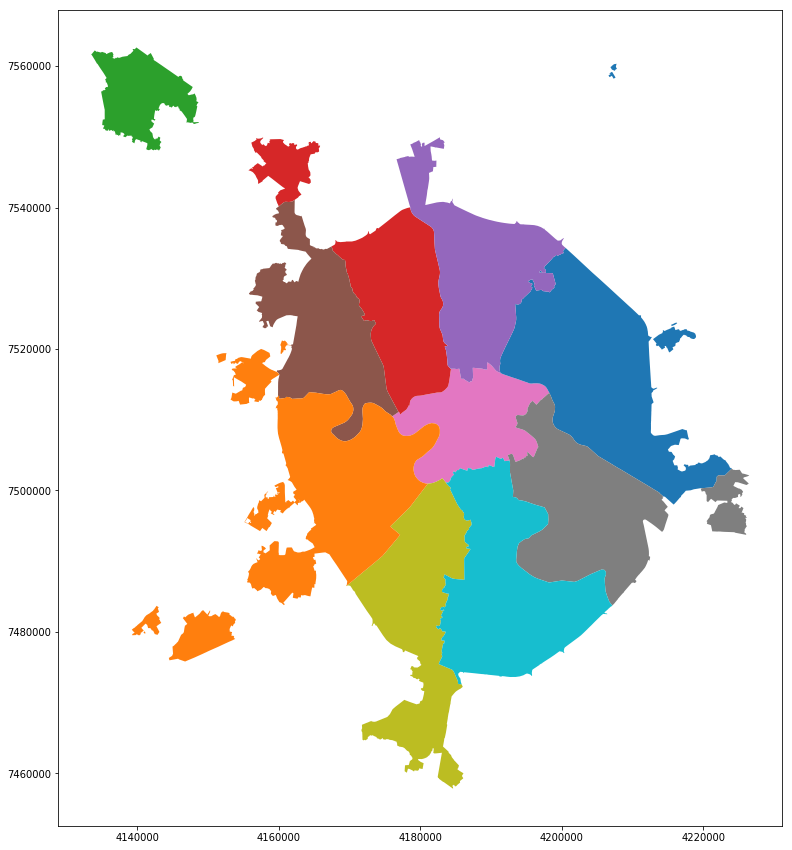

In [7]:
#geopandas из коробки умеет круто рисовать полигоны
geo_data.plot(column='NAME', figsize=[15,15])

Напишем функцию, которая поможет нам посчитать количество голосов по округам

In [8]:
def point_in_polygon(point_x, point_y, polygon):
    p = Point(point_x, point_y)
    p = gpd.GeoSeries(p)
    p.crs = {'init' :'epsg:4326'}
    p = p.to_crs({'init': 'epsg:3857'})
    try:
        result = p.intersects(polygon)
    except:
        raise Exception("Bad data")
    return result[0]

In [9]:
print('ЦАО - ', point_in_polygon(37.555232, 55.712539, geo_data.geometry[0]),'\n'
      'ЗАО - ', point_in_polygon(37.554210, 55.710278, geo_data.geometry[0]))

ЦАО -  True 
ЗАО -  False


In [10]:
def district(point_x, point_y, geo_data):
    right_district = 'Unknown'
    for distr in geo_data.index:
        if point_in_polygon(point_x, point_y, geo_data.loc[distr][1]):
            right_district = geo_data.loc[distr][0]
            return right_district
    return right_district

In [11]:
print('ЦАО - ', district(37.555232, 55.712539, geo_data),'\n'
      'ЗАО - ', district(37.554210, 55.710278, geo_data))

ЦАО -  Центральный административный округ 
ЗАО -  Западный административный округ


In [26]:
geo_clear = geo[['x', 'y']].drop_duplicates()
geo_districts_set = {}
for point in geo_clear.index:
    geo_districts_set[(geo_clear.loc[point].x, geo_clear.loc[point].y)] = district(geo_clear.loc[point].x, geo_clear.loc[point].y, geo_data)
    print(point)

0
2
3
4
7
9
10
11
12
13
14
15
17
18
19
20
22
23
24
27
29
30
51
100
137
139
140
142
143
144
145
147
155
156
157
205
269
271
302
303
378
403
424
425
432
457
460
494
496
503
506
507
508
509
545
549
615
616
617
618
619
621
625
644
647
649
748
749
750
751
766
796
806
807
808
823
824
825
826
827
828
838
849
851
852
854
855
901
902
903
904
905
906
907
909
910
911
912
913
914
915
916
917
936
937
971
972
975
1025
1026
1027
1028
1029
1030
1031
1032
1033
1036
1050
1069
1070
1077
1078
1079
1100
1101
1102
1103
1104
1105
1106
1107
1135
1136
1137
1138
1139
1140
1141
1144
1145
1163
1164
1165
1195
1197
1198
1200
1201
1202
1203
1204
1240
1244
1266
1267
1268
1304
1310
1321
1324
1326
1337
1338
1356
1361
1362
1363
1364
1365
1366
1368
1369
1370
1371
1372
1398
1456
1457
1460
1462
1471
1473
1474
1475
1476
1477
1479
1480
1481
1482
1483
1491
1495
1496
1497
1499
1500
1501
1502
1513
1514
1515
1516
1517
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1536
1538
1539
1540
1541
1542
1543
1544
1547
1548
1549
1551
15

KeyboardInterrupt: 

Доделаю это ДЗ